In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import itertools
from config_valid import Config, TrainingMode
import matplotlib.pyplot as plt
from plot_funcs import plot_dim1, plot_dimN, plot_correlation_error, plot_metrics
from plt_parameters import init_params
init_params()

In [2]:
with open('test_loss_ER_6class_19dic22.pkl', 'rb') as file:
    test_loss = pickle.load(file)

In [3]:
with open('embedding_ER_6class_19dic22.pkl', 'rb') as file:
    embedding_class = pickle.load(file)

In [4]:
num_emb_neurons=6

In [5]:
config_file = "configurations/classification_ER6class_19dic22.yml"
c = Config(config_file)

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


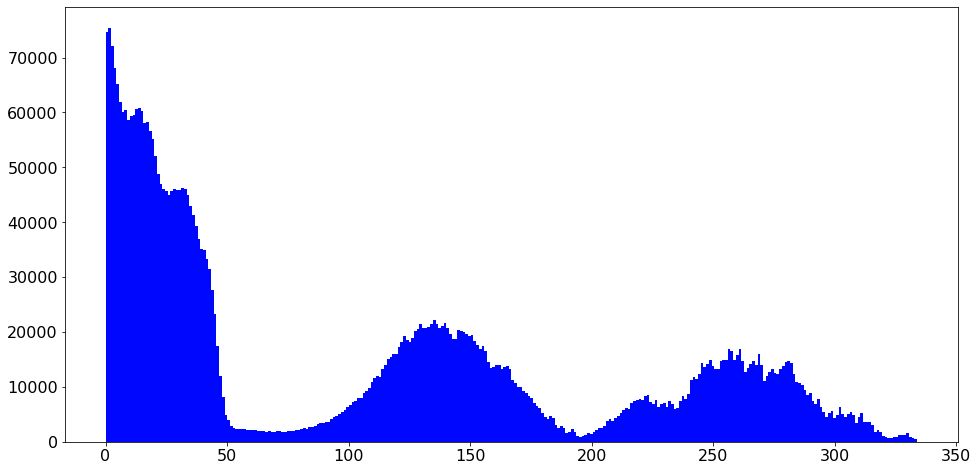

In [6]:
plot_metrics(embedding_class, num_emb_neurons, c.modo)


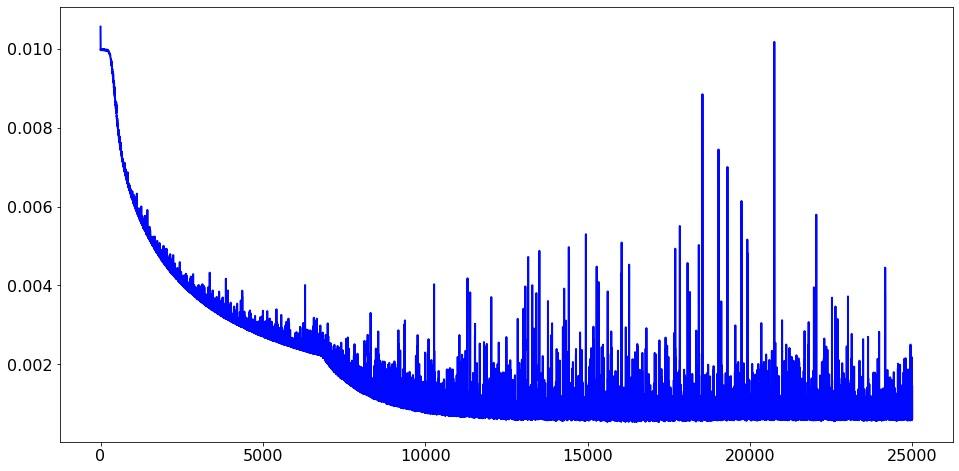

In [7]:
plt.plot(test_loss);  #array_wo_outliers

In [8]:
single_labels = embedding_class.get_all_scalar_labels_per_class()

In [9]:
len(embedding_class.emb_perclass)

6

In [10]:
graphemb_perclass = np.array(embedding_class.get_all_graph_emb_per_class())
graphemb_perclass.shape, graphemb_perclass[0].shape

((6, 200, 6), (200, 6))

In [11]:
#np.equal([graphembclass[c,:] for c in coppie_classi], [graphembclass[c,:,:] for c in coppie_classi]).all()
#out: True

In [12]:
# intra distances
def calc_coppie_intracluster(graph_emb_cluster):
    NN = graph_emb_cluster.shape[0]
    coppie_numeric = list(itertools.combinations(range(NN), 2))
    coppie = graph_emb_cluster[coppie_numeric]
    #coppie_labels = le stesse per tutti
    distances = []
    for a, b in coppie:
        dist = np.linalg.norm(a-b)
        distances.append(dist)
    return distances


def calc_coppie_multiclass(embedding_class):
    graphemb_perclass = np.array(embedding_class.get_all_graph_emb_per_class())
    
    # calcolo le inter-cluster distances
    NN = len(graphemb_perclass)
    coppie_classi = list(itertools.combinations(range(NN), 2))
    coppie_labels_class = [(embedding_class.emb_perclass[c[0]][0].scalar_label, embedding_class.emb_perclass[c[1]][0].scalar_label) for c in coppie_classi]
    coppie_gemb_perclass = [graphemb_perclass[c,:] for c in coppie_classi]

    inter_dists_perclass = []
    for cluster_a, cluster_b in coppie_gemb_perclass:
        inter_dists_ab = []
        NN = len(cluster_a)  # assumo sia la stessa per tutti i cluster
        coppie_ab = list(itertools.combinations(range(NN), 2))
        for ca, cb in coppie_ab:
            a = cluster_a[ca]
            b = cluster_b[cb]
            dist = np.linalg.norm(a-b)
            inter_dists_ab.append(dist)
        inter_dists_perclass.append(inter_dists_ab)
    
    # calcolo le intra-cluster distances
    intra_dists_perclass = []
    for i in range(len(graphemb_perclass)):
        intra_dists_perclass.append(calc_coppie_intracluster(graphemb_perclass[i]))
    single_labels = embedding_class.get_all_scalar_labels_per_class()
                           
    return inter_dists_perclass, intra_dists_perclass, coppie_labels_class, single_labels

In [13]:
inter_dists_perclass, intra_dists_perclass, coppie_labels_class, single_labels = calc_coppie_multiclass(embedding_class)
labels_str = [str(i).strip('(').strip(')').replace(',',' <->') for i in coppie_labels_class]    

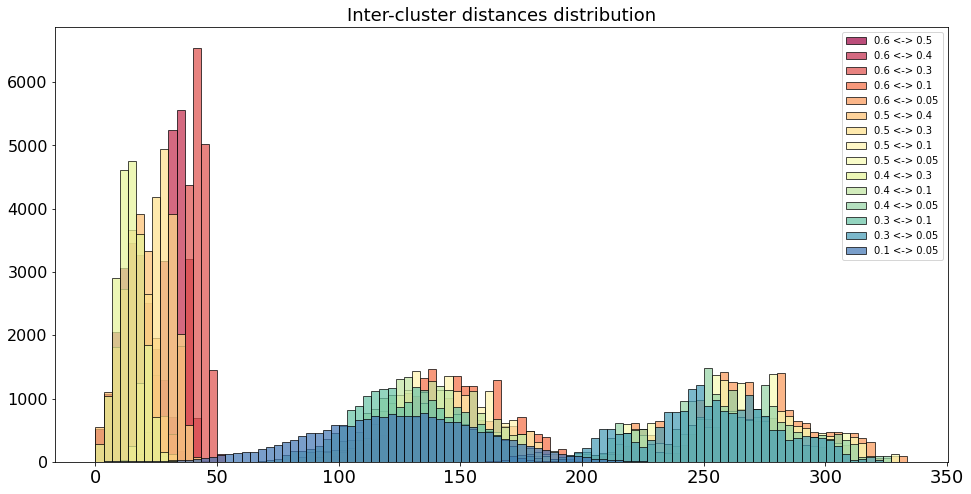

In [24]:
plot_dim1(inter_dists_perclass, bins=100, want_kde=False, density=False, labels=labels_str, title="Inter-cluster distances distribution", nomefile="inter_cluster_many_class.png")

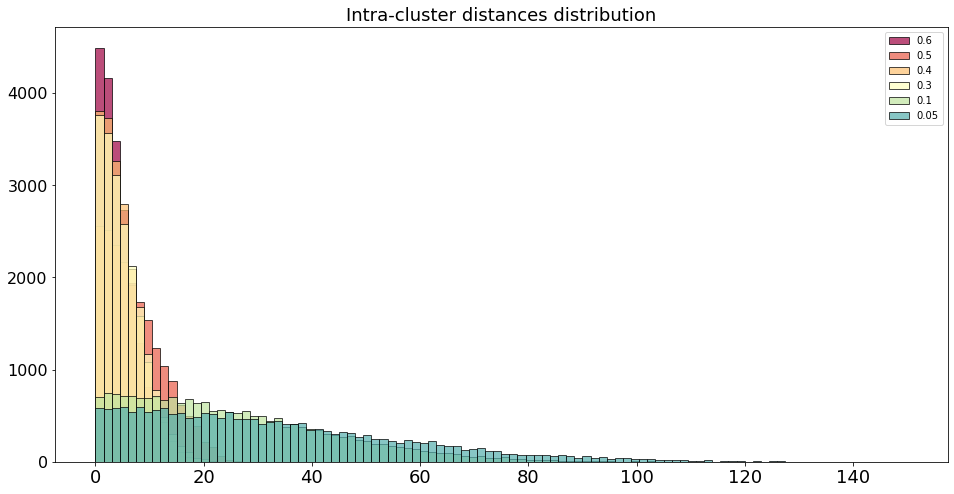

In [23]:
plot_dim1(intra_dists_perclass, bins=100, want_kde=False, density=False, labels=single_labels, title="Intra-cluster distances distribution", nomefile="intra_cluster_many_class.png")